In [3]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

### Helper functions that are used in the rest of the notebook

In [4]:
def extract_nodes(df):
    """
    Extracts the nodes from a dataframe
    :param df: dataframe with source and target columns
    :return: set of nodes
    """
    return set(df['source'].unique()).union(set(df['target'].unique()))

def load_nodes(file_path):
    """
    Loads the nodes from a file
    :param file_path: path to the file
    :return: set of nodes
    """
    # much faster to do the operations on dataframes
    df = pd.read_csv(file_path, delimiter = ' ', names=['source', 'target', 'day'])
    nodes = extract_nodes(df)
    print(f"loaded {file_path} has {len(nodes)} nodes")
    return nodes

def largest_connected_component(G):
    """
    Returns the largest connected component of a graph
    :param G: graph
    :return: largest connected component
    """
    # not supported for directed networks
    subgraphs = sorted(nx.connected_components(G), key=len, reverse=True)
    return G.subgraph(subgraphs[0])

def build_network(df, directed = False):
    """
    Builds a network from a dataframe
    :param df: dataframe with source and target columns
    :param directed: whether the network is directed or not
    :return: networkx graph
    """
    if directed:
        G = nx.DiGraph()
    else:
        G = nx.Graph()

    # Check if exists a day column
    if "day" in df.columns:
        to_add = [(source, target, {"day": day}) for source, target, day in zip(df["source"], df["target"], df["day"])]
    else:
        to_add = zip(df["source"], df["target"])
    G.add_edges_from(to_add)
    return G

def extract_bidirectional_subnetwork(G):
    """
    creates an undirected sub network from a directed network

    that only contains the edges where both

    u -> v and v -> u

    are in the directed network. In the followers/following sense,

    This extracts the sub network where the users follow eachother.

    """
    sub_G = nx.Graph()

    for e in G.edges:
        if len(e) == 2:
            u, v = e
        else:
            u, v, _ = e
        if G.has_edge(v, u):
            sub_G.add_edge(u,v)

    return sub_G

def load_subnetwork(file_path, sub_nodes, directed = False):
    """
    Loads a network from a file and extracts a subnetwork by only keeping the nodes in sub_nodes
    :param file_path: path to the file with the network
    :param sub_nodes: set of nodes to keep
    :param directed: whether the network is directed or not
    :return: networkx graph
    """

    df = pd.read_csv(file_path, delimiter = ' ', names=['source', 'target', 'day'])
    if df['day'].isna().all():
        df.drop(columns=['day'], inplace=True)
    sub_df = df[((df['source'].isin(sub_nodes)) & (df['target'].isin(sub_nodes)))]

    return build_network(sub_df, directed)

def get_friendships(G):
    """
    Extracts the friendships from a social network defined as the subnetwork where both u -> v and v -> u are in the network
    :param G: social network
    :return: friendships network
    """

    G = extract_bidirectional_subnetwork(G)

    return G.to_undirected()

def get_lcc(G, directed = False):
    """
    Returns the largest connected component of a graph
    :param G: graph
    :param directed: whether the graph is directed or not
    :return: largest connected component
    """
    lcc = largest_connected_component(G.to_undirected())

    if directed:
        return lcc.to_directed()
    else:
        return lcc.to_undirected()

def get_subgraph(G, max_n_of_nodes=None, is_seed_node_most_connected=True, seed = None):
    """
    Returns a subgraph of G with k nodes generated by BFS from a seed node
    :param G: graph
    :param k: number of nodes in the subgraph
    :param is_seed_node_most_connected: whether the seed node is the most connected node or a random node
    :param seed: seed node, random if None
    :return: subgraph
    """
    if max_n_of_nodes is None:
        max_n_of_nodes = G.number_of_nodes() // 5

    if seed:
        seed_node = seed
    elif is_seed_node_most_connected:
        seed_node = max(G.degree(), key=lambda x: x[1])[0]
    else:
        # Choosing a random node does not guarantee getting a subgraph of the desired size
        seed_node = random.choice(list(G.nodes()))
    # Initialize a queue for BFS and a set for visited nodes
    queue = [seed_node]
    visited = set([seed_node])
    # Initialize the subgraph with the starting node
    subgraph = nx.Graph()
    subgraph.add_node(seed_node)
    # While the subgraph has fewer than n nodes and the queue is not empty
    while len(subgraph) < max_n_of_nodes and queue:
        # Get the next node from the queue
        curr_node = queue.pop(0)
        # Add its neighbors that have not been visited to the queue and the subgraph
        for neighbor in G.neighbors(curr_node):
            if neighbor not in visited:
                if len(subgraph) >= max_n_of_nodes:
                    break
                visited.add(neighbor)
                subgraph.add_node(neighbor)
                subgraph.add_edge(curr_node, neighbor, day=G[curr_node][neighbor]["day"])
                queue.append(neighbor)
    # print n of nodes in the subgraph 
    print(f"subgraph has {len(subgraph)} nodes")
    return subgraph


def build_df_from_graph(graph):
    graph_df = pd.DataFrame(graph.edges(data=True), columns=['source', 'target', 'attribute'])
    # Extract the 'day' attribute from the 'attribute' column and add it as a separate column
    graph_df['timestamp'] = [d['day'] for d in graph_df['attribute']]
    min_t = min(graph_df['timestamp'])

    # Hardcoded normalizing to ~1000 timesteps
    graph_df['day'] = ((graph_df['timestamp'] - min_t) / 600).astype(int)
    # subgraph_df['day'] = ((subgraph_df['timestamp'] - min_t)).astype(int)

    # Drop the 'attribute' column, which is no longer needed
    graph_df.drop('attribute', axis=1, inplace=True)

    graph_df.sort_values('day')

    # Simulate temporal spreading starting from the node with the highest average degree
    graph_df = graph_df.sort_values(by=['day'])
    graph_df.reset_index(drop=True, inplace=True)
    return graph_df


### Create the dataset of replies, mentions and retweets with real timestamps (not just days)

In [5]:
activity_time_path = "../network-data/higgs-activity_time.txt"
activity_time = pd.read_csv(activity_time_path, delimiter = ' ', names=['source', 'target', 'time', 'type'])

In [7]:
# create high resolution timestamped datasets
reply_timestamps_file_path = "../output/reply_timestamps.edgelist"
mention_timestamps_file_path = "../output/mention_timestamps.edgelist"
retweet_timestamps_file_path = "../output/retweet_timestamps.edgelist"

activity_time[activity_time['type'] == 'RE'][['source', 'target', 'time']]\
.to_csv(reply_timestamps_file_path, sep=' ', header=False, index=False)
replies = activity_time[activity_time['type'] == 'RE'].copy()
# replies[['source', 'target']] = replies[['target', 'source']]
replies[['source', 'target', 'time']].to_csv(reply_timestamps_file_path, sep=' ', header=False, index=False)
# activity_time[activity_time['type'] == 'MT'][['source', 'target', 'time']]\
# .to_csv(mention_timestamps_file_path, sep=' ', header=False, index=False)
mentions = activity_time[activity_time['type'] == 'MT'].copy()
#mentions[['source', 'target']] = mentions[['target', 'source']]
mentions[['source', 'target', 'time']].to_csv(retweet_timestamps_file_path, sep=' ', header=False, index=False)
# Swap source and target columns in the retweet dataset to effectively simulate the dataflow (as mentioned on the website)
retweets = activity_time[activity_time['type'] == 'RT'].copy()
retweets[['source', 'target']] = retweets[['target', 'source']]
retweets[['source', 'target', 'time']].to_csv(retweet_timestamps_file_path, sep=' ', header=False, index=False)

In [8]:
social_file_path = "../network-data/higgs-social_network.edgelist"

### Create the intersection of nodes across all interaction mechanisms.

In [9]:

reply_nodes = load_nodes(reply_timestamps_file_path)
mention_nodes = load_nodes(mention_timestamps_file_path)
reply_mention_nodes = reply_nodes.intersection(mention_nodes)
del reply_nodes, mention_nodes


retweet_nodes = load_nodes(retweet_timestamps_file_path)
reply_mention_retweet_nodes = reply_mention_nodes.intersection(retweet_nodes)
del reply_mention_nodes, retweet_nodes

print(f"intersected network has {len(reply_mention_retweet_nodes)} nodes")

loaded ../output/reply_timestamps.edgelist has 38918 nodes
loaded ../output/mention_timestamps.edgelist has 116408 nodes
loaded ../output/retweet_timestamps.edgelist has 256491 nodes
intersected network has 21346 nodes


### Create the social network and the friendship network

In [10]:
# following/followers is a directed network
social_network = load_subnetwork(social_file_path, reply_mention_retweet_nodes, directed=True)
# Print information about the directionality of the network
lcc_social_network = get_lcc(social_network)
friends_network = get_friendships(social_network)
print(friends_network)
print(social_network)
print(lcc_social_network)
del social_network
lcc_friends_network = get_lcc(friends_network)
del friends_network

nx.write_edgelist(lcc_friends_network, '../output/higgs-friends-lcc.edgelist')
nx.write_edgelist(lcc_social_network, '../output/higgs-social-lcc.edgelist')

Graph with 17186 nodes and 84592 edges
DiGraph with 21193 nodes and 569025 edges
Graph with 21114 nodes and 484392 edges


### Create the subnetworks for replies, mentions and retweets bby only keeping the nodes that are present in the social network or the friendship network.

In [11]:
social_reply_network = load_subnetwork(reply_timestamps_file_path, lcc_social_network.nodes, directed=True)
social_mention_network = load_subnetwork(mention_timestamps_file_path, lcc_social_network.nodes, directed=True)
social_retweet_network = load_subnetwork(retweet_timestamps_file_path, lcc_social_network.nodes, directed=True)
print(social_reply_network)
print(social_mention_network)
print(social_retweet_network)
friends_reply_network = load_subnetwork(reply_timestamps_file_path, lcc_friends_network.nodes, directed=True)
friends_mention_network = load_subnetwork(mention_timestamps_file_path, lcc_friends_network.nodes, directed=True)
friends_retweet_network = load_subnetwork(retweet_timestamps_file_path, lcc_friends_network.nodes, directed=True)
print(friends_reply_network)
print(friends_mention_network)
print(friends_retweet_network)
paths = ['../output/higgs-social-reply.edgelist', '../output/higgs-social-mention.edgelist', '../output/higgs-social-retweet.edgelist', '../output/higgs-friends-reply.edgelist', '../output/higgs-friends-mention.edgelist', '../output/higgs-friends-retweet.edgelist']
networks = [social_reply_network, social_mention_network, social_retweet_network, friends_reply_network, friends_mention_network, friends_retweet_network]


for path, network in zip(paths, networks):
    nx.write_edgelist(network, path)
    with open(path, 'r') as f:
        data = f.readlines()

    # Remove the "day" key from each line of data
    data = [line.strip().replace("{'day': ", "").replace("}", "") for line in data]

    # Convert the data into a list of tuples with integer values
    data = [tuple(map(int, line.split())) for line in data]

    # Write the modified data to a new file
    with open(path, 'w') as f:
        for line in data:
            f.write(f"{line[0]} {line[1]} {line[2]}\n")



DiGraph with 16937 nodes and 14687 edges
DiGraph with 18222 nodes and 32143 edges
DiGraph with 17094 nodes and 30906 edges
DiGraph with 11949 nodes and 10558 edges
DiGraph with 13173 nodes and 24736 edges
DiGraph with 12043 nodes and 23041 edges


In [15]:
friends_file_path = "../output/higgs-friends-lcc.edgelist"
friends_reply_path = "../output/higgs-friends-reply.edgelist"
friends_mention_path = "../output/higgs-friends-mention.edgelist"
friends_retweet_path = "../output/higgs-friends-retweet.edgelist"

social_file_path = "../output/higgs-friends-lcc.edgelist"
social_reply_path = "../output/higgs-friends-reply.edgelist"
social_mention_path = "../output/higgs-friends-mention.edgelist"
social_retweet_path = "../output/higgs-friends-retweet.edgelist"

### Temporal analysis of the reply network (Can be skipped now that we have a better way to do it presented in the next section)

In [13]:
"""G_reply = nx.read_edgelist(friends_reply_path, data=(("day", int),), create_using=nx.DiGraph)
subgraph_reply = get_subgraph(G_reply, 5000, is_seed_node_most_connected=True)
print(subgraph_reply.number_of_nodes())
subgraph_reply_df = pd.DataFrame(subgraph_reply.edges(data=True), columns=['source', 'target', 'attribute'])
# Extract the 'day' attribute from the 'attribute' column and add it as a separate column
subgraph_reply_df['timestamp'] = [d['day'] for d in subgraph_reply_df['attribute']]
min_t = min(subgraph_reply_df['timestamp'])

# Hardcoded normalizing to ~1000 timesteps
subgraph_reply_df['day'] = ((subgraph_reply_df['timestamp'] - min_t)/ 600).astype(int)
# subgraph_reply_df['day'] = ((subgraph_reply_df['timestamp'] - min_t)).astype(int)
# Drop the 'attribute' column, which is no longer needed
subgraph_reply_df.drop('attribute', axis=1, inplace=True)

# there are days above 7, so we need to remove them
# subgraph_reply_df = subgraph_reply_df[subgraph_reply_df['day'] <= 7]
#unique_days = subgraph_reply_df['day'].unique()
#print(unique_days)

subgraph_reply_df.sort_values('day')
# nx.draw(subgraph_reply)"""

'G_reply = nx.read_edgelist(friends_reply_path, data=(("day", int),), create_using=nx.DiGraph)\nsubgraph_reply = get_subgraph(G_reply, 5000, is_seed_node_most_connected=True)\nprint(subgraph_reply.number_of_nodes())\nsubgraph_reply_df = pd.DataFrame(subgraph_reply.edges(data=True), columns=[\'source\', \'target\', \'attribute\'])\n# Extract the \'day\' attribute from the \'attribute\' column and add it as a separate column\nsubgraph_reply_df[\'timestamp\'] = [d[\'day\'] for d in subgraph_reply_df[\'attribute\']]\nmin_t = min(subgraph_reply_df[\'timestamp\'])\n\n# Hardcoded normalizing to ~1000 timesteps\nsubgraph_reply_df[\'day\'] = ((subgraph_reply_df[\'timestamp\'] - min_t)/ 600).astype(int)\n# subgraph_reply_df[\'day\'] = ((subgraph_reply_df[\'timestamp\'] - min_t)).astype(int)\n# Drop the \'attribute\' column, which is no longer needed\nsubgraph_reply_df.drop(\'attribute\', axis=1, inplace=True)\n\n# there are days above 7, so we need to remove them\n# subgraph_reply_df = subgraph_

In [14]:
"""#  First implementation of temporal spreading
# From the plot I am not sure if this is correct, the number of infected nodes is pretty low,
# but that could be because the huge majority of interactions happen at time 1, and i am considering a node as spreader from the next day is infected
# if we remove this condition I expect the number of infected nodes to be almost the same as the number of nodes in the subgraph at day 1

subgraph_reply_df = subgraph_reply_df.sort_values(by=['day'])
subgraph_reply_df.reset_index(drop=True, inplace=True)

iterations = 1
infected_nodes_time_dict = {0:[1 for _ in range(iterations)]}
seed_nodes = []

min_day = min(subgraph_reply_df['day'])
max_day = max(subgraph_reply_df['day'])
number_of_nodes = len(subgraph_reply.nodes())
for n in range(iterations):
    seed_node = random.choice(list(subgraph_reply.nodes()))
    seed_nodes.append(seed_node)
    infected_nodes = {seed_node}

    cur_timestamp = min_day
    nodes_infected_in_timestamp = set()

    # Iterate over all days
    for day in subgraph_reply_df['day']:
        print(f'Iteration {n+1}/{iterations} : {day}/{max_day} --- ', end='\r')
        # For each day get the edges that were created on that day
        edges = subgraph_reply_df[subgraph_reply_df['day'] == day]
        # Take the dataframe subset where either the source or the target is in the infected nodes
        susceptible_nodes_rows = edges[edges['source'].isin(infected_nodes) | edges['target'].isin(infected_nodes)]
        # Make a set of all the nodes that are in susceptible_nodes_rows
        susceptible_nodes = set(susceptible_nodes_rows['source']).union(set(susceptible_nodes_rows['target']))
        # Add the susceptible nodes to the infected nodes
        infected_nodes = infected_nodes.union(susceptible_nodes)
        # Add the infected nodes to the infected_nodes_time_dict
        if day in infected_nodes_time_dict:
            infected_nodes_time_dict[day].append(len(infected_nodes))
        else:
            infected_nodes_time_dict[day] = [len(infected_nodes)]

    # Take the average of the infected nodes for each timestamp
    infected_nodes_time_dict = {k: [np.sum(v)/(len(v)*number_of_nodes)] for k, v in infected_nodes_time_dict.items()}
    plt.clf()
    plt.plot(list(infected_nodes_time_dict.keys()), list(infected_nodes_time_dict.values()))"""

"#  First implementation of temporal spreading\n# From the plot I am not sure if this is correct, the number of infected nodes is pretty low,\n# but that could be because the huge majority of interactions happen at time 1, and i am considering a node as spreader from the next day is infected\n# if we remove this condition I expect the number of infected nodes to be almost the same as the number of nodes in the subgraph at day 1\n\nsubgraph_reply_df = subgraph_reply_df.sort_values(by=['day'])\nsubgraph_reply_df.reset_index(drop=True, inplace=True)\n\niterations = 1\ninfected_nodes_time_dict = {0:[1 for _ in range(iterations)]}\nseed_nodes = []\n\nmin_day = min(subgraph_reply_df['day'])\nmax_day = max(subgraph_reply_df['day'])\nnumber_of_nodes = len(subgraph_reply.nodes())\nfor n in range(iterations):\n    seed_node = random.choice(list(subgraph_reply.nodes()))\n    seed_nodes.append(seed_node)\n    infected_nodes = {seed_node}\n\n    cur_timestamp = min_day\n    nodes_infected_in_timest

### Try to find correlations between different networks

In [359]:
# G_reply = nx.read_edgelist(social_reply_path, data=(("day", int),), create_using=nx.DiGraph)
# G_mention = nx.read_edgelist(social_mention_path, data=(("day", int),), create_using=nx.DiGraph)
# G_retweet = nx.read_edgelist(social_retweet_path, data=(("day", int),), create_using=nx.DiGraph)

G_reply = nx.read_edgelist(friends_reply_path, data=(("day", int),), create_using=nx.DiGraph)
G_mention = nx.read_edgelist(friends_mention_path, data=(("day", int),), create_using=nx.DiGraph)
G_retweet = nx.read_edgelist(friends_retweet_path, data=(("day", int),), create_using=nx.DiGraph).reverse()

common_nodes = set(G_reply.nodes()).intersection(set(G_mention.nodes())).intersection(set(G_retweet.nodes()))



### Temporal network centrality and correlation between in and out degree

In [360]:
def get_network_time_sliced(G, window_size = 1):
    df = build_df_from_graph(G)
    days = df['day'].unique()
    
    graphs = {}


    min_day = min(days)
    max_day = max(days)
    days = np.arange(min_day, max_day, window_size)

    for day in days:
        period_network_df = df[(df['day'] < (day + window_size)) & (df['day'] >= day)]

        graphs[day] = build_network(period_network_df, directed=True)


    return graphs
    

In [361]:
def create_node_index_dict(G_reply_dict, G_mention_dict, G_retweet_dict):
    """creates node index dict

    Args:
        G_reply_dict (_type_): some dictionary with node keys
        G_mention_dict (_type_): some dictionary with node keys
        G_retweet_dict (_type_): some dictionary with node keys
    """
    i = 0
    node_index_dict = {}
    for k, _ in G_reply_dict.items():
        node_index_dict[k] = i
        i += 1
    for k, _ in G_mention_dict.items():
        if k not in node_index_dict.keys():
            node_index_dict[k] = i
            i += 1
    for k,_ in G_retweet_dict.items():
        if k not in node_index_dict.keys():
            node_index_dict[k] = i
            i += 1
    return node_index_dict

In [362]:
def combine_network_features(G_reply_feature, G_mention_feature, G_retweet_feature):
    """Combine network features accross three seperate networks.

    Reshapes the feature arrays to a universal size and adds a 0 where the node feature is not in the other netwrk

    input should be of form {node_id1 : feature value1, node_id2 : feature value2, ...}

    Args:
        G_reply_feature dict : feature of network 1
        G_mention_feature dict : feature of network 2
        G_retweet_feature dict : feature of network 3 

    Returns:
        f1, f2, f3 : arrays of same shape containing all features of the nodes accross the networks at the same positions.
    """
    node_index_dict = create_node_index_dict(G_reply_feature, G_mention_feature, G_retweet_feature)

    total_length = len(G_reply_feature) + len(G_mention_feature) + len(G_retweet_feature)
    f1 = np.zeros(total_length)
    for k, v in G_reply_feature.items():
        f1[node_index_dict[k]] = v
    f2 = np.zeros(total_length)
    for k, v in G_mention_feature.items():
        f2[node_index_dict[k]] = v
    f3 = np.zeros(total_length)
    for k, v in G_retweet_feature.items():
        f3[node_index_dict[k]] = v

    return f1, f2, f3

In [363]:
# Create the periodic activity graphs and take the intersection on which activities happened in all graphs.

reply_daily_graphs = get_network_time_sliced(G_reply)
mention_daily_graphs = get_network_time_sliced(G_mention)
retweet_daily_graphs = get_network_time_sliced(G_retweet)

daily_graphs = [reply_daily_graphs, mention_daily_graphs, retweet_daily_graphs]

reply_weekly_graphs = get_network_time_sliced(G_reply, window_size=7)
mention_weekly_graphs = get_network_time_sliced(G_mention, window_size=7)
retweet_weekly_graphs = get_network_time_sliced(G_retweet, window_size=7)

weekly_graphs = [reply_weekly_graphs, mention_weekly_graphs, retweet_weekly_graphs]

reply_monthly_graphs = get_network_time_sliced(G_reply, window_size=28)
mention_monthly_graphs = get_network_time_sliced(G_mention, window_size=28)
retweet_monthly_graphs = get_network_time_sliced(G_retweet, window_size=28)

monthly_graphs = [reply_monthly_graphs, mention_monthly_graphs, retweet_monthly_graphs]


In [364]:

def compute_periodic_feature(feature_function, periodic_graphs):
    
    reply_periodic_graphs, mention_periodic_graphs, retweet_periodic_graphs = periodic_graphs
    available_days = set(reply_periodic_graphs.keys()).intersection(set(mention_periodic_graphs.keys())).intersection(set(retweet_periodic_graphs.keys()))
    
    # store the data for each node
    node_dict = {'f_reply' : {}, 'f_mention' : {}, 'f_retweet' : {}}

    # store the data for each day
    day_dict = {'f_reply' : {}, 'f_mention' : {}, 'f_retweet' : {}}

    for i, day in enumerate(available_days):


        f_reply = feature_function(reply_periodic_graphs[day])
        f_mention = feature_function(mention_periodic_graphs[day])
        f_retweet = feature_function(retweet_periodic_graphs[day])
        for k, v in f_reply.items():
            if k not in node_dict['f_reply']:
                node_dict['f_reply'][k] = []
            node_dict['f_reply'][k].append((day, v))

            if day not in day_dict['f_reply']:
                day_dict['f_reply'][day] = {}
            day_dict['f_reply'][day][k] = v


        for k, v in f_mention.items():
            if k not in node_dict['f_mention']:
                node_dict['f_mention'][k] = []
            node_dict['f_mention'][k].append((day, v))

            if day not in day_dict['f_mention']:
                day_dict['f_mention'][day] = {}
            day_dict['f_mention'][day][k] = v

        for k, v in f_retweet.items():
            if k not in node_dict['f_retweet']:
                node_dict['f_retweet'][k] = []
            node_dict['f_retweet'][k].append((day, v))

            
            if day not in day_dict['f_retweet']:
                day_dict['f_retweet'][day] = {}
            day_dict['f_retweet'][day][k] = v
    
    return node_dict, day_dict





In [365]:

daily_in_degree_node_dict, daily_in_degree_day_dict = compute_periodic_feature(lambda x: dict(x.in_degree()), daily_graphs)
daily_out_degree_node_dict, daily_out_degree_day_dict = compute_periodic_feature(lambda x: dict(x.out_degree()), daily_graphs)

weekly_in_degree_node_dict, weekly_in_degree_day_dict = compute_periodic_feature(lambda x: dict(x.in_degree()), weekly_graphs)
weekly_out_degree_node_dict, weekly_out_degree_day_dict = compute_periodic_feature(lambda x: dict(x.out_degree()), weekly_graphs)

monthly_in_degree_node_dict, monthly_in_degree_day_dict = compute_periodic_feature(lambda x: dict(x.in_degree()), monthly_graphs)
monthly_out_degree_node_dict, monthly_out_degree_day_dict = compute_periodic_feature(lambda x: dict(x.out_degree()), monthly_graphs)

In [378]:
def plot_degree_correlation(type_str):
    x = []
    y = []
    days = []
    corrs = []
    for day in daily_in_degree_day_dict[type_str].keys():
        # print(out_degree_day_dict['f_reply'][day].values())
        corrs.append(np.corrcoef(list(daily_out_degree_day_dict[type_str][day].values()), list(daily_in_degree_day_dict[type_str][day].values()))[0][1])
        days.append(day)

        for node in daily_in_degree_day_dict[type_str][day].keys():
            if not node in daily_out_degree_day_dict[type_str][day]:
                continue

            x.append(daily_out_degree_day_dict[type_str][day][node])
            y.append(daily_in_degree_day_dict[type_str][day][node])

    fig = plt.figure(figsize=(16,5))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.scatter(x,y)
    ax1.set_xlabel('out_degree')
    ax1.set_ylabel('in_degree')

    ax2.plot(days, corrs)
    ax2.set_title('correlation of in degree and out degree through out time')

c:\Users\Vince\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]


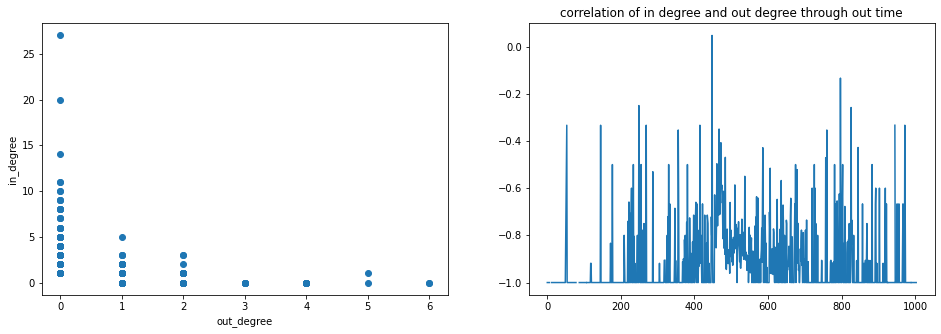

In [379]:
plot_degree_correlation('f_reply')


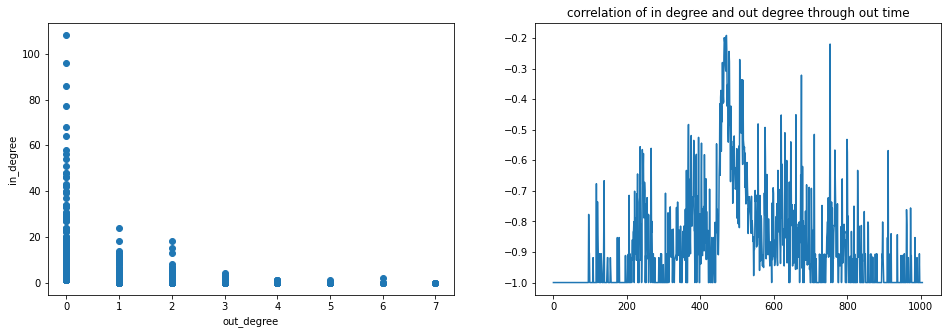

In [380]:
plot_degree_correlation('f_retweet')

c:\Users\Vince\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2821: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
c:\Users\Vince\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2680: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)
c:\Users\Vince\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2680: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
c:\Users\Vince\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


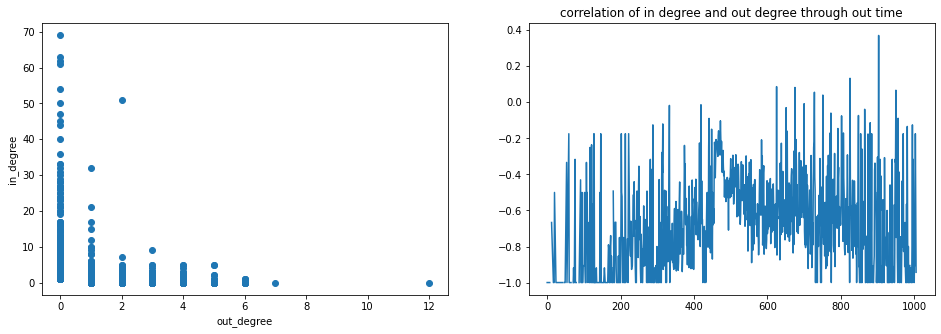

In [381]:
plot_degree_correlation('f_mention')

In [382]:
def create_plot_grid(fig, h, w):
    return [fig.add_subplot(h, w, w*row + col) for row in range(0, h) for col in range(1, w+1)]

In [310]:
# Not really interesting...
# 
# fig = plt.figure(figsize=(16,5))

# ax1, ax2, ax3, ax4, ax5, ax6 = create_plot_grid(fig, 2, 3)

# def p(d, ax):

#     for k, v in d.items():
#         xy = np.array(v)
#         x, y = xy[:, 0], xy[:, 1]

#         # remove nodes with too little data to increase the speed of the plotting by a ton.
#         if len(y) < 20:
#             continue
#         ax.scatter(x, y, alpha=.5, c = 'b')
    

# p(daily_out_degree_node_dict['f_reply'], ax1)
# p(daily_out_degree_node_dict['f_mention'], ax2)
# p(daily_out_degree_node_dict['f_retweet'], ax3)

# p(daily_in_degree_node_dict['f_reply'], ax4)
# p(daily_in_degree_node_dict['f_mention'], ax5)
# p(daily_in_degree_node_dict['f_retweet'], ax6)


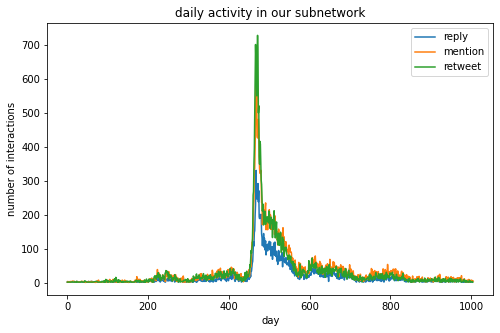

In [313]:
fig = plt.figure(figsize=(8,5))

ax1 = create_plot_grid(fig, 1, 1)[0]


reply_sizes = []
mention_sizes = []
retweet_sizes = []
for day in daily_in_degree_day_dict['f_reply'].values():
    reply_sizes.append(len(day.values()))

for day in daily_in_degree_day_dict['f_mention'].values():
    mention_sizes.append(len(day.values()))

for day in daily_in_degree_day_dict['f_retweet'].values():
    retweet_sizes.append(len(day.values()))

ax1.plot(daily_in_degree_day_dict['f_reply'].keys(), reply_sizes, label = 'reply')
ax1.plot(daily_in_degree_day_dict['f_mention'].keys(), mention_sizes, label ='mention')
ax1.plot(daily_in_degree_day_dict['f_retweet'].keys(), retweet_sizes, label = 'retweet')

ax1.set_title('daily activity in our subnetwork')
ax1.set_ylabel('number of interactions')
ax1.set_xlabel('day')
plt.legend()

Text(0, 0.5, 'correlation')

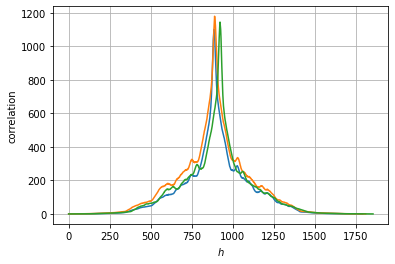

In [342]:
reply_retweet_corr = np.correlate(reply_sizes, retweet_sizes, "full") / (np.std(reply_sizes)* np.std(retweet_sizes))
reply_mention_corr = np.correlate(reply_sizes, mention_sizes, "full") / (np.std(reply_sizes)* np.std(mention_sizes))
retweet_mention_corr = np.correlate(retweet_sizes, mention_sizes, "full") / (np.std(mention_sizes)* np.std(retweet_sizes))
plt.plot(reply_retweet_corr) 
plt.plot(reply_mention_corr)
plt.plot(retweet_mention_corr, label = '')
plt.grid()
plt.xlabel('$h$')
plt.ylabel('corr()')

(-1.0, 1.0)

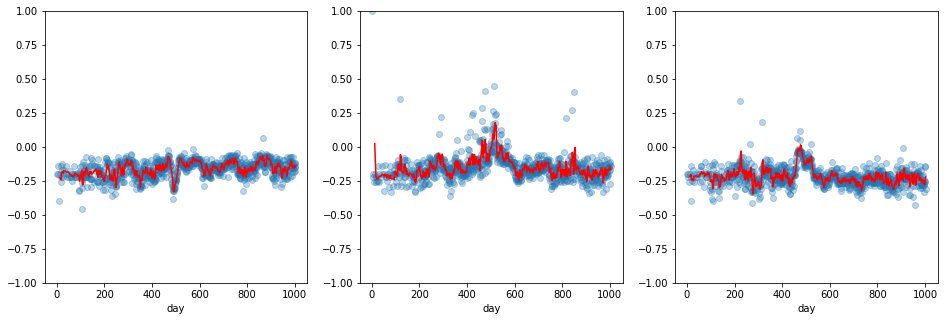

In [316]:
fig = plt.figure(figsize=(16,5))

ax1, ax2, ax3 = create_plot_grid(fig, 1, 3)

reply_retweet_corr = []
reply_mention_corr = []
retweet_mention_corr = []
days = daily_in_degree_day_dict['f_reply'].keys()

for dayf1, dayf2, dayf3 in zip(daily_in_degree_day_dict['f_reply'].values(), daily_in_degree_day_dict['f_mention'].values(), daily_in_degree_day_dict['f_retweet'].values()):
    reply_feature, mention_feature, retweet_feature = combine_network_features(dayf1, dayf2, dayf3)
    reply_retweet_corr.append(np.corrcoef(reply_feature, retweet_feature)[0,1])
    reply_mention_corr.append(np.corrcoef(reply_feature, mention_feature)[0,1])
    retweet_mention_corr.append(np.corrcoef(retweet_feature, mention_feature)[0,1])


df = pd.DataFrame([days, reply_retweet_corr, reply_mention_corr, retweet_mention_corr]).T
df.columns = ['day', 'reply_retweet_corr', 'reply_mention_corr', 'retweet_mention_corr']

mean = df[['reply_retweet_corr', 'reply_mention_corr', 'retweet_mention_corr']].rolling(5).mean()

ax1.scatter(days, reply_retweet_corr, alpha=.3)
ax1.plot(days, mean['reply_retweet_corr'], c= 'r')
ax2.scatter(days, reply_mention_corr, alpha=.3)
ax2.plot(days, mean['reply_mention_corr'], c= 'r')
ax3.scatter(days, retweet_mention_corr, alpha=.3)
ax3.plot(days, mean['retweet_mention_corr'], c= 'r')


ax1.set_xlabel('day')
ax2.set_xlabel('day')
ax3.set_xlabel('day')

ax1.set_ylim(-1, 1)
ax2.set_ylim(-1, 1)
ax3.set_ylim(-1, 1)

### Static Network centrality Correlation


In [317]:


def make_plot(axes, plot_data, plot_args, plot_func):
    for i, ax in enumerate(axes):
        plot_func(ax, *plot_data[i], *plot_args[i])


In [318]:
def make_correlation_plot(reply_feature, mention_feature, retweet_feature, feature_name):

    def _do_plot(ax, x, y, x_label, y_label):
        ax.scatter(x, y, alpha=0.2)
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)

    fig = plt.figure(figsize=(16,5))
    axes = create_plot_grid(fig, 1, 3)
    plot_data = [[reply_feature, retweet_feature], [reply_feature, mention_feature], [retweet_feature, mention_feature]]
    plot_args = [['reply', 'retweet'], ['reply', 'mention'], ['retweet', 'mention']]
    plot_args = [[f"{e[0]} {feature_name}", f"{e[1]} {feature_name}"] for e in plot_args]
    make_plot(axes, plot_data, plot_args, _do_plot)

    fig.suptitle(f'correlation of {feature_name}')
    

In [320]:
def get_network_correlation(reply_feature_dict: dict, mention_feature_dict: dict, retweet_feature_dict: dict, feature_name: str, plot=True):

    # Leave only the rows where the source and the target are unique pairs
    # subgraph_reply_unique_df = subgraph_reply_df.drop_duplicates(subset=['source', 'target'])
    # degrees = subgraph_reply_unique_df.groupby('source').count()

    reply_feature, mention_feature, retweet_feature = combine_network_features(reply_feature_dict, mention_feature_dict, retweet_feature_dict)
    # Remove trailing zeros from the arrays
    # reply_degrees_array = reply_degrees_array[~np.all(reply_degrees_array == 0)]
    # retweet_degrees_array = retweet_degrees_array[~np.all(retweet_degrees_array == 0)]
    # mention_degrees_array = mention_degrees_array[~np.all(mention_degrees_array == 0)]

    # Calculate the correlation between the degrees of the different networks
    print(f"Correlation between reply and retweet {feature_name}: {np.corrcoef(reply_feature, retweet_feature)[0,1]}")
    print(f"Correlation between reply and mention {feature_name}: {np.corrcoef(reply_feature, mention_feature)[0,1]}")
    print(f"Correlation between retweet and mention {feature_name}: {np.corrcoef(retweet_feature, mention_feature)[0,1]}")

    if plot:
        make_correlation_plot(reply_feature, mention_feature, retweet_feature, feature_name)



Correlation between reply and retweet in_degree: 0.16154477499228856
Correlation between reply and mention in_degree: 0.8793300466989546
Correlation between retweet and mention in_degree: 0.09998941996223568


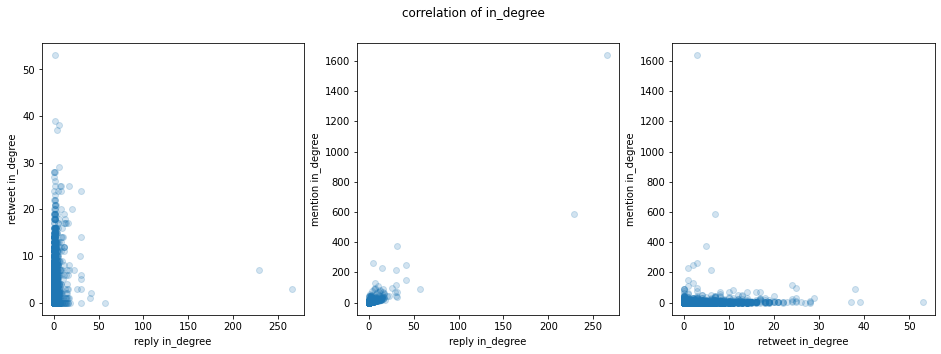

In [321]:
get_network_correlation(dict(G_reply.in_degree()), dict(G_mention.in_degree()), dict(G_retweet.in_degree()), "in_degree")

Correlation between reply and retweet out_degree: 0.09721784647241945
Correlation between reply and mention out_degree: 0.7228490431331797
Correlation between retweet and mention out_degree: 0.1517223241255208


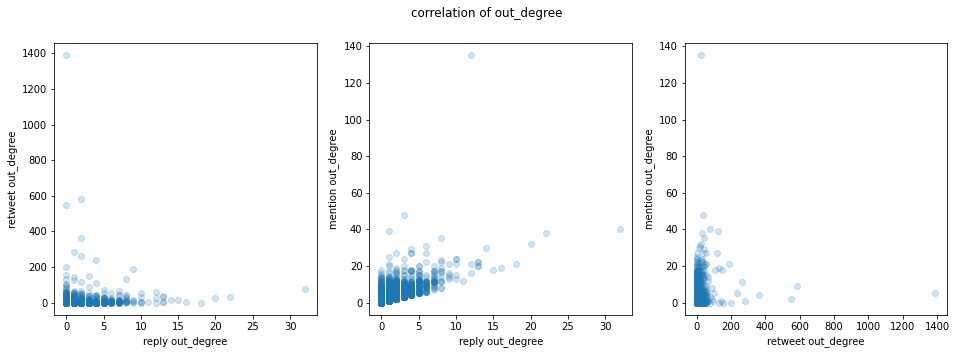

In [322]:
get_network_correlation(dict(G_reply.out_degree()), dict(G_mention.out_degree()), dict(G_retweet.out_degree()), "out_degree")

Correlation between reply and retweet degree_centrality: 0.8120655437413211
Correlation between reply and mention degree_centrality: 0.8589445369855078
Correlation between retweet and mention degree_centrality: 0.9073545375115868


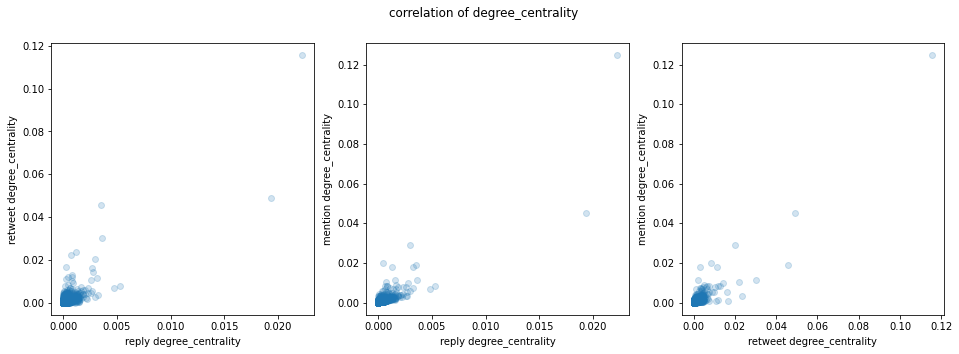

In [323]:
get_network_correlation(nx.centrality.degree_centrality(G_reply), nx.centrality.degree_centrality(G_mention), nx.centrality.degree_centrality(G_retweet), "degree_centrality")

Correlation between reply and retweet out_degree_centrality: 0.09721784647241957
Correlation between reply and mention out_degree_centrality: 0.7228490431332025
Correlation between retweet and mention out_degree_centrality: 0.15172232412552222


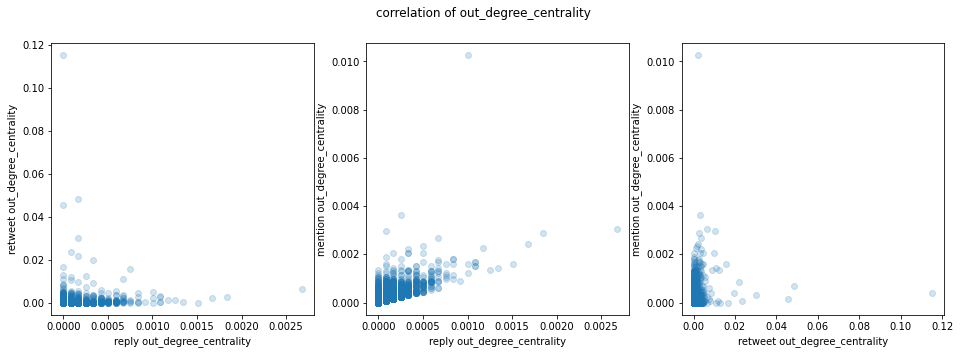

In [314]:
get_network_correlation(nx.centrality.out_degree_centrality(G_reply), nx.centrality.out_degree_centrality(G_mention), nx.centrality.out_degree_centrality(G_retweet), "out_degree_centrality")

Correlation between reply and retweet closeness_centrality: 0.209346134913436
Correlation between reply and mention closeness_centrality: 0.641078844966278
Correlation between retweet and mention closeness_centrality: 0.26182529422618245


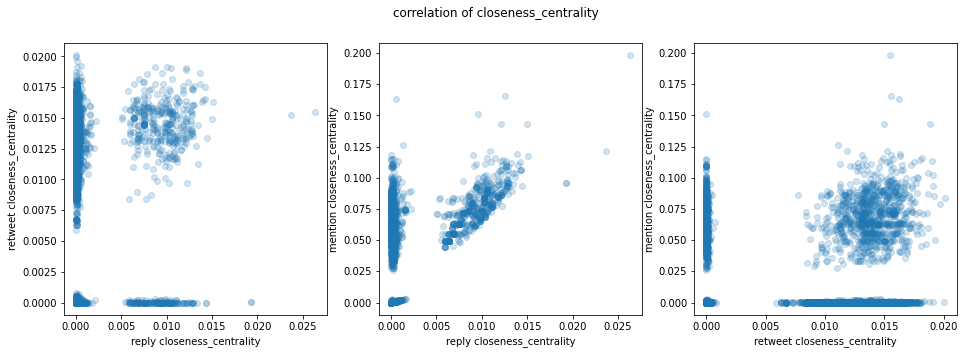

In [324]:
# looks interesting :-) but I cannot interpret the result really...
get_network_correlation(nx.centrality.closeness_centrality(G_reply), nx.centrality.closeness_centrality(G_mention), nx.centrality.closeness_centrality(G_retweet), "closeness_centrality")

### Calculate autocorrelation of the number of infected nodes when starting from the node with maximum average degree

In [289]:
# Get only the nodes that have non-zero degree in all the networks
common_nodes = set(G_reply.nodes()).intersection(set(G_mention.nodes())).intersection(set(G_retweet.nodes()))
# Construct a subgraph of each of the reply/mention/retweet graphs with only the common nodes but edges between nodes that are not in the common nodes
print(G_reply.number_of_nodes())
print(G_mention.number_of_nodes())
print(G_retweet.number_of_nodes())
print(len(common_nodes))
G_common_reply = G_reply.subgraph(common_nodes)
G_common_mention = G_mention.subgraph(common_nodes)
G_common_retweet = G_retweet.subgraph(common_nodes)
print(G_common_reply.number_of_nodes())
print(G_common_mention.number_of_nodes())
print(G_common_retweet.number_of_nodes())
# Create degrees_array with the degrees of the nodes in the common nodes subgraph
degrees_array = np.zeros(total_length)
# finding the average max degree in this way, has the risk of having a node with very low degree in one of the networks and very high degree in the other two, as it is the case
for node in G_common_reply.nodes():
    degrees_array[node_index_dict[node]] = np.sqrt(G_common_reply.out_degree(node)) + np.sqrt(G_common_mention.out_degree(node)) + np.sqrt(G_common_retweet.out_degree(node))
# Get the index of the node with the maximum average degree
# print("Degrees", degrees_array)
# Get index of the maximum degree
max_degree_index = np.argmax(degrees_array)
# Get the node with the maximum average degree
max_degree_node = list(node_index_dict.keys())[list(node_index_dict.values()).index(max_degree_index)]

In [ ]:
# Start spreading from the node with the maximal out_degree in each of the networks
max_degree_reply = max(G_reply.out_degree(), key=lambda x: x[1])[0]
max_degree_retweet = max(G_retweet.out_degree(), key=lambda x: x[1])[0]
max_degree_mention = max(G_mention.out_degree(), key=lambda x: x[1])[0]
print(G_reply.out_degree(max_degree_reply))
print(G_retweet.out_degree(max_degree_retweet))
print(G_mention.out_degree(max_degree_mention))
# Get the subgraph of the node with the maximum average degree
subgraph_reply = get_subgraph(G_reply, max_n_of_nodes=5000, seed=max_degree_reply)
subgraph_mention = get_subgraph(G_mention, max_n_of_nodes=5000, seed=max_degree_mention)
subgraph_retweet = get_subgraph(G_retweet, max_n_of_nodes=5000, seed=max_degree_retweet)
print(subgraph_retweet)
print(subgraph_mention)
print(subgraph_reply)

In [290]:
# Functions for simulating spreading
def simulate_spreading(graph_df, seed_nodes, start_day, end_day, name="name_not_given", plot=True):

    infected_nodes_ratio_time_count = []
    infected_nodes_new = []
    
    for i, seed_node in enumerate(seed_nodes):
        
        infected_nodes_time = []
        infected_nodes = {seed_node}

        min_day = start_day
        max_day = end_day
        number_of_nodes = len(subgraph_reply.nodes())

        # Iterate over all days
        for day in np.arange(min_day, max_day+1):
            print(f'Graph: {name} Node: {i+1}/{len(seed_nodes)} Timestamp: {day}/{max_day} --- ', end='\r')
            # For each day get the edges that were created on that day
            edges = graph_df[graph_df['day'] == day]
            # Take the dataframe subset where either the source or the target is in the infected nodes
            susceptible_nodes_rows = edges[edges['source'].isin(infected_nodes) | edges['target'].isin(infected_nodes)]
            # Make a set of all the nodes that are in susceptible_nodes_rows
            susceptible_nodes = set(susceptible_nodes_rows['source']).union(set(susceptible_nodes_rows['target']))
            # Add the susceptible nodes to the infected nodes
            infected_nodes = infected_nodes.union(susceptible_nodes)
            # Add the infected nodes to the infected_nodes_time_dict
            infected_nodes_time.append(infected_nodes.copy())

        # Take the number of infected nodes per timestamp
        infected_nodes_ratio_time_count_it = [len(infected_nodes)/number_of_nodes for infected_nodes in infected_nodes_time]
        # Add legend to the plot

        last_infected_n = 0
        infected_nodes_new_it = []

        # add the difference between current infected and last infected
        for inf_nodes in infected_nodes_time:
            n_inf = len(inf_nodes) - last_infected_n
            infected_nodes_new_it.append(n_inf/number_of_nodes)
            last_infected_n = len(inf_nodes)
            
        infected_nodes_ratio_time_count.append(infected_nodes_ratio_time_count_it)
        infected_nodes_new.append(infected_nodes_new_it)
    
    # average over iterations
    infected_nodes_ratio_time_count = np.mean(infected_nodes_ratio_time_count, axis=0)
    infected_nodes_new = np.mean(infected_nodes_new, axis=0)

    if plot:
        plt.plot(np.arange(min_day, max_day+1), infected_nodes_new, label=f'{name}', alpha=0.8)
        plt.legend()
    return infected_nodes_ratio_time_count, infected_nodes_new



In [291]:
# Start spreading from the node with the maximal out_degree in each of the networks
max_degree_reply = max(G_reply.out_degree(), key=lambda x: x[1])[0]
max_degree_retweet = max(G_retweet.out_degree(), key=lambda x: x[1])[0]
max_degree_mention = max(G_mention.out_degree(), key=lambda x: x[1])[0]
print(G_reply.out_degree(max_degree_reply))
print(G_retweet.out_degree(max_degree_retweet))
print(G_mention.out_degree(max_degree_mention))
# Get the subgraph of the node with the maximum average degree
subgraph_reply = get_subgraph(G_reply, max_n_of_nodes=5000, seed=max_degree_reply)
subgraph_mention = get_subgraph(G_mention, max_n_of_nodes=5000, seed=max_degree_mention)
subgraph_retweet = get_subgraph(G_retweet, max_n_of_nodes=5000, seed=max_degree_retweet)
print(subgraph_retweet)
print(subgraph_mention)
print(subgraph_reply)

32
1388
135
subgraph has 523 nodes
subgraph has 1650 nodes
subgraph has 5000 nodes
Graph with 5000 nodes and 4999 edges
Graph with 1650 nodes and 1649 edges
Graph with 523 nodes and 522 edges


In [ ]:
# Functions for simulating spreading
def simulate_spreading(graph_df, seed_nodes, start_day, end_day, name="name_not_given", plot=True):

    infected_nodes_ratio_time_count = []
    infected_nodes_new = []
    
    for i, seed_node in enumerate(seed_nodes):
        
        infected_nodes_time = []
        infected_nodes = {seed_node}

        min_day = start_day
        max_day = end_day
        number_of_nodes = len(subgraph_reply.nodes())

        # Iterate over all days
        for day in np.arange(min_day, max_day+1):
            print(f'Graph: {name} Node: {i+1}/{len(seed_nodes)} Timestamp: {day}/{max_day} --- ', end='\r')
            # For each day get the edges that were created on that day
            edges = graph_df[graph_df['day'] == day]
            # Take the dataframe subset where either the source or the target is in the infected nodes
            susceptible_nodes_rows = edges[edges['source'].isin(infected_nodes) | edges['target'].isin(infected_nodes)]
            # Make a set of all the nodes that are in susceptible_nodes_rows
            susceptible_nodes = set(susceptible_nodes_rows['source']).union(set(susceptible_nodes_rows['target']))
            # Add the susceptible nodes to the infected nodes
            infected_nodes = infected_nodes.union(susceptible_nodes)
            # Add the infected nodes to the infected_nodes_time_dict
            infected_nodes_time.append(infected_nodes.copy())

        # Take the number of infected nodes per timestamp
        infected_nodes_ratio_time_count_it = [len(infected_nodes)/number_of_nodes for infected_nodes in infected_nodes_time]
        # Add legend to the plot

        last_infected_n = 0
        infected_nodes_new_it = []

        # add the difference between current infected and last infected
        for inf_nodes in infected_nodes_time:
            n_inf = len(inf_nodes) - last_infected_n
            infected_nodes_new_it.append(n_inf/number_of_nodes)
            last_infected_n = len(inf_nodes)
            
        infected_nodes_ratio_time_count.append(infected_nodes_ratio_time_count_it)
        infected_nodes_new.append(infected_nodes_new_it)
    
    # average over iterations
    infected_nodes_ratio_time_count = np.mean(infected_nodes_ratio_time_count, axis=0)
    infected_nodes_new = np.mean(infected_nodes_new, axis=0)

    if plot:
        plt.plot(np.arange(min_day, max_day+1), infected_nodes_new, label=f'{name}', alpha=0.8)
        plt.legend()
    return infected_nodes_ratio_time_count, infected_nodes_new



In [292]:
# select random nodes
random_node = np.random.choice(G_common_reply.nodes(), 10)
# random_node = '1988'
print(random_node, [degrees_array[node_index_dict[node]] for node in random_node])

In [293]:
# Simulate spreading for the node with the maximum average degree
print(subgraph_reply)
# Build dataframes for each graph
subgraph_reply_df = build_df_from_graph(subgraph_reply)
subgraph_mention_df = build_df_from_graph(subgraph_mention)
subgraph_retweet_df = build_df_from_graph(subgraph_retweet)

start_day_reply = min(subgraph_reply_df['day'])
start_day_mention = min(subgraph_mention_df['day'])
start_day_retweet = min(subgraph_retweet_df['day'])
end_day_reply = max(subgraph_reply_df['day'])
end_day_mention = max(subgraph_mention_df['day'])
end_day_retweet = max(subgraph_retweet_df['day'])

start_day = min(start_day_reply, start_day_mention, start_day_retweet)
end_day = max(end_day_reply, end_day_mention, end_day_retweet)
start_node = random_node

reply_infection_rates, reply_new_infected = simulate_spreading(subgraph_reply_df, start_node, start_day, end_day, name="reply")
mention_infection_rates, mention_new_infected = simulate_spreading(subgraph_mention_df, start_node, start_day, end_day, name="mention")
retweet_infection_rates, retweet_new_infected = simulate_spreading(subgraph_retweet_df, start_node, start_day, end_day, name="retweet")


['75716' '303509' '121433' '110413' '115089' '16948' '310651' '22167'
 '173230' '199020'] [0.0, 3.8284271247461903, 4.146264369941973, 0.0, 2.8284271247461903, 2.414213562373095, 3.0, 0.0, 2.0, 2.0]


Graph with 523 nodes and 522 edges


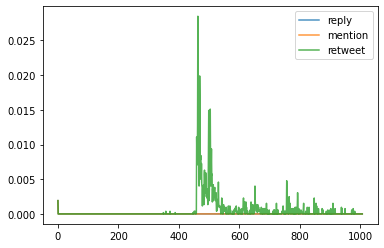

In [294]:
correlation_reply_mention = np.correlate(reply_new_infected, mention_new_infected, "full")
correlation_reply_retweet = np.correlate(reply_new_infected, retweet_new_infected, "full")
correlation_mention_retweet = np.correlate(mention_new_infected, retweet_new_infected, "full")
print(correlation_reply_mention)

correlation_reply_mention /= np.max(np.abs(correlation_reply_mention), axis=0)
correlation_reply_retweet /= np.max(np.abs(correlation_reply_retweet), axis=0)
correlation_mention_retweet /= np.max(np.abs(correlation_mention_retweet), axis=0)

plt.clf()
plt.plot(correlation_reply_mention, label="reply-mention", alpha=0.8)
plt.plot(correlation_reply_retweet, label="reply-retweet", alpha=0.8)
plt.plot(correlation_mention_retweet, label="mention-retweet", alpha=0.8)
plt.legend()
plt.title("Correlation between infection rates")

[0. 0. 0. ... 0. 0. 0.]


Text(0.5, 1.0, 'Correlation between infection rates')

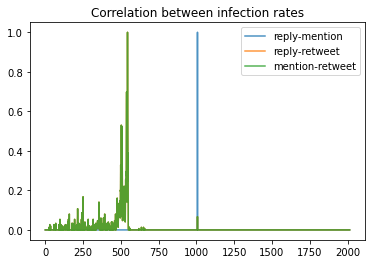

In [296]:

correlation_reply_mention = np.corrcoef(reply_infection_rates, mention_infection_rates)[0][1]
corr_coefs = []
for i in range(len(reply_infection_rates)):
    corr_coefs.append(np.corrcoef(reply_infection_rates[:-i], mention_infection_rates[i:])[0][1])
correlation_reply_retweet = np.corrcoef(reply_infection_rates, retweet_infection_rates)[0][1]
correlation_mention_retweet = np.corrcoef(mention_infection_rates, retweet_infection_rates)[0][1]
print(correlation_reply_mention)
plt.clf()
plt.plot(corr_coefs, label="reply-mention")
plt.plot(correlation_reply_retweet, label="reply-retweet")
plt.plot(correlation_mention_retweet, label="mention-retweet")
plt.legend()
plt.title("Correlation between infection rates")

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 0 and the array at index 1 has size 1008